### File Explanation

**trainRNN_AttentionModel_learningRate.ipynb:**
<br> This notebook is to load AddNeuroMed examples from 'preprocessData.pickle', create an "Attention Network" and train the network with respect to a range of learning rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer dynamic model from fixed length sequences (function: **dynamicLSTM_Attention** in **trainRNN_network_utils.py**)
<br> 5) Create an attention mechanism based on a fully-connected layer of states and output, which is followed by a tanh layer to calculate scores. Then, calculate attention weights and context vector using softmax and dense layers 
<br> 6) Create a single output from a concatenation of context vectors of gene A and gene B
<br> 7) Pass the output through a **dense** layer and make prediction
<br> 8) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 9) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 10) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 11) Save them in "resultsAttentionLearningRate_ANM.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 5) **attention_matrixA**: Attention weights of gene A, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 6) **attention_matrixB**: Attention weights of gene B, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 7) **tst_prediction**: Test predictions, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])

In [1]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import pandas as pd
import sys
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [2]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData.ipynb"

# Save data into Python file
import pickle
with open('preprocessData.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )

# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data loaded from pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 206
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [6]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropout = 0.4                                       # dropout percentage

## Training data
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_size = 150
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches
lambda_l2_reg = 0.0001

### Network and Train

In [7]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
attention_matrixA = {}
attention_matrixB = {}
tst_prediction = {}

for learning_rate in learning_rates:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_A, current_state_A = dynamicLSTM_Attention(rSnpRnaA_pXNS, 
                                                                 n_layer, 
                                                                 n_hidden, 
                                                                 dropout)

    hidden_state_A = current_state_A[-1].h

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_B, current_state_B = dynamicLSTM_Attention(rSnpRnaB_pXNS, 
                                                                 n_layer, 
                                                                 n_hidden, 
                                                                 dropout)

    hidden_state_B = current_state_B[-1].h

    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')

    context_vectorA, attention_weightsA = attention(hidden_state_A, hidden_output_A, n_hidden)
    context_vectorB, attention_weightsB = attention(hidden_state_B, hidden_output_B, n_hidden)

    encoding = tf.concat((context_vectorA, context_vectorB), axis=1)

    # Dense Layer
    logits = tf.layers.dense(encoding,
                            units = n_classes, 
                            activation = None,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(0.4),
                            kernel_initializer = tf.initializers.random_normal() )

    prediction = tf.argmax(logits, 1)

    l2 = lambda_l2_reg * sum(
        tf.nn.l2_loss(tf_var)
            for tf_var in tf.trainable_variables()
            if not ("bias" in tf_var.name))

    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                                         labels=tf.argmax(rRelated_pXC,1)) + l2)

    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(prediction, tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Precision and recall
    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = prediction)
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = prediction)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelated_tXC               
                    })

                tst_loss, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
            

            if epoch_idx == (n_epoch-1):

                for i in range(rSnpRnaA_tst_nXNS.shape[0]):
                    rSnpRnaA_tst_nXNSA = np.expand_dims(rSnpRnaA_tst_nXNS[i], axis=0)
                    rSnpRnaB_tst_nXNSB = np.expand_dims(rSnpRnaB_tst_nXNS[i], axis=0)
                    rRelated_tst_nXC_ = np.expand_dims(rRelated_tst_nXC[i], axis=0)

                    pred, at_weightA, at_weightB = sess.run(
                        [prediction, attention_weightsA, attention_weightsB],
                        feed_dict = {
                                rSnpRnaA_pXNS: rSnpRnaA_tst_nXNSA,
                                rSnpRnaB_pXNS: rSnpRnaB_tst_nXNSB,
                                rRelated_pXC: rRelated_tst_nXC_
                                }) 

                    at_weightA = np.reshape(at_weightA, (-1, 1))
                    at_weightB = np.reshape(at_weightB, (-1, 1))

                    attention_matrixA[dropout] = at_weightA
                    attention_matrixB[dropout] = at_weightB                    
                    tst_prediction[dropout] = pred
    
        trainLosses[learning_rate] = train_losses
        testLosses[learning_rate] = test_losses
        trainAccuracy[learning_rate] = train_accuracies
        F1_scores[learning_rate] = test_f1_score
        print("Optimisation finished!")

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.8674402236938477: Accuracy = 0.31333333253860474
Performance on test set: : Loss = 1.857262134552002: Accuracy = 0.6862385403966704

Data shuffled. Epoch: 

Performance on training data: Loss = 1.6677664518356323: Accuracy = 0.653333306312561
Performance on test set: : Loss = 2.6424763202667236: Accuracy = 0.5744959620320712

Data shuffled. Epoch:  28
Performance on training data: Loss = 1.762153148651123: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 2.6174888610839844: Accuracy = 0.5764319181010307

Data shuffled. Epoch:  29
Performance on training data: Loss = 1.628322958946228: Accuracy = 0.5866666436195374
Performance on test set: : Loss = 2.7599446773529053: Accuracy = 0.5776283663571397

Data shuffled. Epoch:  30
Performance on training data: Loss = 1.6876583099365234: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 2.619511365890503: Accuracy = 0.5775882298112269

Data shuffled. Epoch:  31
Performance on training data: Loss = 1.7418715953826904: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 3.1505651473999023: Accuracy = 0.5791885930974383

Data shuffled. Epoch:  32
Performance on

Performance on training data: Loss = 2.6655197143554688: Accuracy = 0.6333333253860474
Performance on test set: : Loss = 3.9762966632843018: Accuracy = 0.5816090619088433

Data shuffled. Epoch:  70
Performance on training data: Loss = 2.707841157913208: Accuracy = 0.5933333039283752
Performance on test set: : Loss = 4.167789936065674: Accuracy = 0.5791520304006625

Data shuffled. Epoch:  71
Performance on training data: Loss = 2.85345458984375: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 3.81087589263916: Accuracy = 0.5782172689220241

Data shuffled. Epoch:  72
Performance on training data: Loss = 2.889230251312256: Accuracy = 0.5533333420753479
Performance on test set: : Loss = 3.73873233795166: Accuracy = 0.5779298972086242

Data shuffled. Epoch:  73
Performance on training data: Loss = 2.6131162643432617: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 3.7866597175598145: Accuracy = 0.5776741344986052

Data shuffled. Epoch:  74
Performance on trai

Performance on training data: Loss = 1.535571575164795: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 3.2131426334381104: Accuracy = 0.5736616461613998

Data shuffled. Epoch:  112
Performance on training data: Loss = 1.4601624011993408: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 2.927279233932495: Accuracy = 0.5740414281005601

Data shuffled. Epoch:  113
Performance on training data: Loss = 1.4516345262527466: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 3.2579843997955322: Accuracy = 0.5740957213967618

Data shuffled. Epoch:  114
Performance on training data: Loss = 1.4978901147842407: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 2.9948737621307373: Accuracy = 0.5739502763482934

Data shuffled. Epoch:  115
Performance on training data: Loss = 1.4597253799438477: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 3.1718695163726807: Accuracy = 0.573277684682004

Data shuffled. Epoch:  116
Performa

Performance on training data: Loss = 1.4811222553253174: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 3.0050621032714844: Accuracy = 0.5513634051454706

Data shuffled. Epoch:  154
Performance on training data: Loss = 1.5049039125442505: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 2.5328304767608643: Accuracy = 0.5509936024427715

Data shuffled. Epoch:  155
Performance on training data: Loss = 1.564693808555603: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 2.5155951976776123: Accuracy = 0.5512110715208246

Data shuffled. Epoch:  156
Performance on training data: Loss = 1.4973453283309937: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 2.8095295429229736: Accuracy = 0.5508817887516608

Data shuffled. Epoch:  157
Performance on training data: Loss = 1.4475959539413452: Accuracy = 0.699999988079071
Performance on test set: : Loss = 2.8403751850128174: Accuracy = 0.5501970007546527

Data shuffled. Epoch:  158
Perform

Performance on training data: Loss = 1.2002395391464233: Accuracy = 0.6866666674613953
Performance on test set: : Loss = 3.532977342605591: Accuracy = 0.5306666892519224

Data shuffled. Epoch:  196
Performance on training data: Loss = 1.2092206478118896: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 3.080698251724243: Accuracy = 0.5297525494654856

Data shuffled. Epoch:  197
Performance on training data: Loss = 1.2410774230957031: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 3.0952975749969482: Accuracy = 0.5289704151175832

Data shuffled. Epoch:  198
Performance on training data: Loss = 1.3517647981643677: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 3.2808635234832764: Accuracy = 0.5279417829381297

Data shuffled. Epoch:  199
Performance on training data: Loss = 1.2394150495529175: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 3.50117826461792: Accuracy = 0.5271788620566876

Optimisation finished!
Data shuffled

Performance on training data: Loss = 0.33061137795448303: Accuracy = 0.846666693687439
Performance on test set: : Loss = 4.949495792388916: Accuracy = 0.37322375246409956

Data shuffled. Epoch:  38
Performance on training data: Loss = 0.33916157484054565: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 4.620508670806885: Accuracy = 0.37673284940822555

Data shuffled. Epoch:  39
Performance on training data: Loss = 0.418275386095047: Accuracy = 0.753333330154419
Performance on test set: : Loss = 4.13986873626709: Accuracy = 0.3783666890621517

Data shuffled. Epoch:  40
Performance on training data: Loss = 0.36973899602890015: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 4.13541316986084: Accuracy = 0.38066211275178413

Data shuffled. Epoch:  41
Performance on training data: Loss = 0.4546400308609009: Accuracy = 0.7666666507720947
Performance on test set: : Loss = 3.943737506866455: Accuracy = 0.38534640953907

Data shuffled. Epoch:  42
Performance on t

Performance on training data: Loss = 0.3504824936389923: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 4.661862850189209: Accuracy = 0.46594109924504645

Data shuffled. Epoch:  80
Performance on training data: Loss = 0.4110081195831299: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 4.200943946838379: Accuracy = 0.4674986574588932

Data shuffled. Epoch:  81
Performance on training data: Loss = 0.32232311367988586: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 4.5184736251831055: Accuracy = 0.4688030447186156

Data shuffled. Epoch:  82
Performance on training data: Loss = 0.344148725271225: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 4.38109827041626: Accuracy = 0.4698114833175458

Data shuffled. Epoch:  83
Performance on training data: Loss = 0.33665674924850464: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 4.754934310913086: Accuracy = 0.47063268361129623

Data shuffled. Epoch:  84
Performance 

Performance on training data: Loss = 0.36714059114456177: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 5.206371307373047: Accuracy = 0.496049872447276

Data shuffled. Epoch:  122
Performance on training data: Loss = 0.34393471479415894: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 5.196707725524902: Accuracy = 0.4964995594596069

Data shuffled. Epoch:  123
Performance on training data: Loss = 0.3486531972885132: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 5.116718769073486: Accuracy = 0.4971603693443618

Data shuffled. Epoch:  124
Performance on training data: Loss = 0.3499903976917267: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 5.52435827255249: Accuracy = 0.49773284996755207

Data shuffled. Epoch:  125
Performance on training data: Loss = 0.4382385313510895: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 4.801537990570068: Accuracy = 0.49842508142448083

Data shuffled. Epoch:  126
Performa

Performance on training data: Loss = 0.2775647044181824: Accuracy = 0.8933333158493042
Performance on test set: : Loss = 5.538504600524902: Accuracy = 0.5185047920313912

Data shuffled. Epoch:  164
Performance on training data: Loss = 0.3516140878200531: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 5.628596782684326: Accuracy = 0.5190696863131242

Data shuffled. Epoch:  165
Performance on training data: Loss = 0.3046228289604187: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 5.763737201690674: Accuracy = 0.5195846938227054

Data shuffled. Epoch:  166
Performance on training data: Loss = 0.3148479759693146: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 5.753059387207031: Accuracy = 0.5198916158391124

Data shuffled. Epoch:  167
Performance on training data: Loss = 0.33395707607269287: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 5.855998992919922: Accuracy = 0.5204583574900058

Data shuffled. Epoch:  168
Performan

Performance on training data: Loss = 0.8600255250930786: Accuracy = 0.5066666603088379
Performance on test set: : Loss = 1.2598422765731812: Accuracy = 0.5426022366494374

Data shuffled. Epoch:  6
Performance on training data: Loss = 0.7803236246109009: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.40866219997406: Accuracy = 0.5602080473989632

Data shuffled. Epoch:  7
Performance on training data: Loss = 0.7407858967781067: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.2646517753601074: Accuracy = 0.5791591560119455

Data shuffled. Epoch:  8
Performance on training data: Loss = 0.7266144752502441: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 1.38730788230896: Accuracy = 0.5922426020001024

Data shuffled. Epoch:  9
Performance on training data: Loss = 0.6642382740974426: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.3841692209243774: Accuracy = 0.6027060274852031

Data shuffled. Epoch:  10
Performance on tra

Performance on training data: Loss = 0.34010612964630127: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 3.8137760162353516: Accuracy = 0.5911284052570623

Data shuffled. Epoch:  48
Performance on training data: Loss = 0.31978631019592285: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 3.7387349605560303: Accuracy = 0.5906253376651233

Data shuffled. Epoch:  49
Performance on training data: Loss = 0.3579525649547577: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 3.7087483406066895: Accuracy = 0.5914977593659029

Data shuffled. Epoch:  50
Performance on training data: Loss = 0.31949183344841003: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 3.8584859371185303: Accuracy = 0.5918684625088273

Data shuffled. Epoch:  51
Performance on training data: Loss = 0.3096219003200531: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 3.7322845458984375: Accuracy = 0.5920031826627554

Data shuffled. Epoch:  52
Perform

Performance on training data: Loss = 0.29330629110336304: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 4.7302422523498535: Accuracy = 0.6031559870580852

Data shuffled. Epoch:  90
Performance on training data: Loss = 0.29095980525016785: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 4.551088333129883: Accuracy = 0.6037404288000228

Data shuffled. Epoch:  91
Performance on training data: Loss = 0.25059056282043457: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 4.803689002990723: Accuracy = 0.6043736494585412

Data shuffled. Epoch:  92
Performance on training data: Loss = 0.2532772719860077: Accuracy = 0.8866666555404663
Performance on test set: : Loss = 4.833725929260254: Accuracy = 0.6047165844880399

Data shuffled. Epoch:  93
Performance on training data: Loss = 0.3148154020309448: Accuracy = 0.846666693687439
Performance on test set: : Loss = 4.715570449829102: Accuracy = 0.605001652132334

Data shuffled. Epoch:  94
Performance o

Performance on training data: Loss = 0.24840141832828522: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 5.366066932678223: Accuracy = 0.6131523657948436

Data shuffled. Epoch:  132
Performance on training data: Loss = 0.20453575253486633: Accuracy = 0.8999999761581421
Performance on test set: : Loss = 5.700401306152344: Accuracy = 0.6133848881548588

Data shuffled. Epoch:  133
Performance on training data: Loss = 0.25128719210624695: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 5.504150390625: Accuracy = 0.6133667134170487

Data shuffled. Epoch:  134
Performance on training data: Loss = 0.29006049036979675: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 5.345869541168213: Accuracy = 0.6137081429193981

Data shuffled. Epoch:  135
Performance on training data: Loss = 0.2745531499385834: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 5.9914326667785645: Accuracy = 0.6135766431297472

Data shuffled. Epoch:  136
Performa

Performance on training data: Loss = 0.2724415063858032: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 6.046905517578125: Accuracy = 0.6128607022829992

Data shuffled. Epoch:  174
Performance on training data: Loss = 0.28773367404937744: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 5.837103843688965: Accuracy = 0.6125679749845053

Data shuffled. Epoch:  175
Performance on training data: Loss = 0.2382020354270935: Accuracy = 0.8999999761581421
Performance on test set: : Loss = 6.076885223388672: Accuracy = 0.6124841895875898

Data shuffled. Epoch:  176
Performance on training data: Loss = 0.2627332806587219: Accuracy = 0.8866666555404663
Performance on test set: : Loss = 5.785064220428467: Accuracy = 0.6125702920542817

Data shuffled. Epoch:  177
Performance on training data: Loss = 0.2610238194465637: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 5.831130027770996: Accuracy = 0.6123501720076143

Data shuffled. Epoch:  178
Performan

Performance on training data: Loss = 0.9002698659896851: Accuracy = 0.5133333206176758
Performance on test set: : Loss = 1.1745463609695435: Accuracy = 0.5438414842850127

Data shuffled. Epoch:  16
Performance on training data: Loss = 0.9684865474700928: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.1978129148483276: Accuracy = 0.5461279108353165

Data shuffled. Epoch:  17
Performance on training data: Loss = 0.8913997411727905: Accuracy = 0.5
Performance on test set: : Loss = 1.1743063926696777: Accuracy = 0.5470350806022057

Data shuffled. Epoch:  18
Performance on training data: Loss = 0.9835106134414673: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.1710153818130493: Accuracy = 0.5473559871748831

Data shuffled. Epoch:  19
Performance on training data: Loss = 0.8403347134590149: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.1323121786117554: Accuracy = 0.5508283420564807

Data shuffled. Epoch:  20
Performance on training

Performance on training data: Loss = 0.574684202671051: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.5931072235107422: Accuracy = 0.6022000375606282

Data shuffled. Epoch:  58
Performance on training data: Loss = 0.6714776158332825: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.624295949935913: Accuracy = 0.6028877434058952

Data shuffled. Epoch:  59
Performance on training data: Loss = 0.6095874309539795: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.5721185207366943: Accuracy = 0.6033278834528638

Data shuffled. Epoch:  60
Performance on training data: Loss = 0.589979350566864: Accuracy = 0.653333306312561
Performance on test set: : Loss = 1.6757045984268188: Accuracy = 0.6036577782756999

Data shuffled. Epoch:  61
Performance on training data: Loss = 0.5939834117889404: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.671773076057434: Accuracy = 0.6035985265963351

Data shuffled. Epoch:  62
Performance on 

Performance on training data: Loss = 0.5218141078948975: Accuracy = 0.753333330154419
Performance on test set: : Loss = 2.1275813579559326: Accuracy = 0.6092599054804241

Data shuffled. Epoch:  100
Performance on training data: Loss = 0.5025103092193604: Accuracy = 0.7666666507720947
Performance on test set: : Loss = 2.079827070236206: Accuracy = 0.609267496876878

Data shuffled. Epoch:  101
Performance on training data: Loss = 0.5074304938316345: Accuracy = 0.753333330154419
Performance on test set: : Loss = 2.2695133686065674: Accuracy = 0.6093157963940952

Data shuffled. Epoch:  102
Performance on training data: Loss = 0.484098881483078: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 2.326500177383423: Accuracy = 0.6092224981379992

Data shuffled. Epoch:  103
Performance on training data: Loss = 0.5008578896522522: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 2.4296047687530518: Accuracy = 0.6093215048316164

Data shuffled. Epoch:  104
Performance

Performance on training data: Loss = 0.45813655853271484: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 2.7506024837493896: Accuracy = 0.6070305388271199

Data shuffled. Epoch:  142
Performance on training data: Loss = 0.4427759349346161: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 2.741398334503174: Accuracy = 0.6069361528053722

Data shuffled. Epoch:  143
Performance on training data: Loss = 0.41000404953956604: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 2.8191418647766113: Accuracy = 0.606867161758167

Data shuffled. Epoch:  144
Performance on training data: Loss = 0.4450705349445343: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 2.913769483566284: Accuracy = 0.606706231129056

Data shuffled. Epoch:  145
Performance on training data: Loss = 0.381642609834671: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 2.9333133697509766: Accuracy = 0.6065975758321068

Data shuffled. Epoch:  146
Performa

Performance on training data: Loss = 0.38558924198150635: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 3.100900650024414: Accuracy = 0.6013582351683463

Data shuffled. Epoch:  184
Performance on training data: Loss = 0.36311209201812744: Accuracy = 0.846666693687439
Performance on test set: : Loss = 3.2270090579986572: Accuracy = 0.6013281761913973

Data shuffled. Epoch:  185
Performance on training data: Loss = 0.39990970492362976: Accuracy = 0.846666693687439
Performance on test set: : Loss = 3.235114812850952: Accuracy = 0.6011750863070761

Data shuffled. Epoch:  186
Performance on training data: Loss = 0.4513334035873413: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 3.232227325439453: Accuracy = 0.6010605452363547

Data shuffled. Epoch:  187
Performance on training data: Loss = 0.44369232654571533: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 3.2695322036743164: Accuracy = 0.6010484842931205

Data shuffled. Epoch:  188
Perfor

Performance on training data: Loss = 1.1068973541259766: Accuracy = 0.41999998688697815
Performance on test set: : Loss = 1.2495849132537842: Accuracy = 0.6305699374610809

Data shuffled. Epoch:  26
Performance on training data: Loss = 1.0812395811080933: Accuracy = 0.47333332896232605
Performance on test set: : Loss = 1.2817105054855347: Accuracy = 0.6266850411523808

Data shuffled. Epoch:  27
Performance on training data: Loss = 1.0892319679260254: Accuracy = 0.4266666769981384
Performance on test set: : Loss = 1.2828019857406616: Accuracy = 0.6230653684195121

Data shuffled. Epoch:  28
Performance on training data: Loss = 1.079732060432434: Accuracy = 0.4866666793823242
Performance on test set: : Loss = 1.2839958667755127: Accuracy = 0.6195380313146378

Data shuffled. Epoch:  29
Performance on training data: Loss = 1.1123926639556885: Accuracy = 0.40666666626930237
Performance on test set: : Loss = 1.2678428888320923: Accuracy = 0.6160081297289097

Data shuffled. Epoch:  30
Performa

Performance on training data: Loss = 0.9994949102401733: Accuracy = 0.5066666603088379
Performance on test set: : Loss = 1.3236452341079712: Accuracy = 0.5567324638929007

Data shuffled. Epoch:  68
Performance on training data: Loss = 1.0588126182556152: Accuracy = 0.3933333456516266
Performance on test set: : Loss = 1.3265753984451294: Accuracy = 0.5560564746387634

Data shuffled. Epoch:  69
Performance on training data: Loss = 1.017487645149231: Accuracy = 0.4933333396911621
Performance on test set: : Loss = 1.3330903053283691: Accuracy = 0.5554814175178521

Data shuffled. Epoch:  70
Performance on training data: Loss = 0.9537506103515625: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.3253703117370605: Accuracy = 0.5548107081646939

Data shuffled. Epoch:  71
Performance on training data: Loss = 0.9905160665512085: Accuracy = 0.4933333396911621
Performance on test set: : Loss = 1.3268998861312866: Accuracy = 0.5542569078115815

Data shuffled. Epoch:  72
Performance

Performance on training data: Loss = 0.9293224811553955: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.2790004014968872: Accuracy = 0.5695241943309542

Data shuffled. Epoch:  110
Performance on training data: Loss = 0.9057525396347046: Accuracy = 0.5933333039283752
Performance on test set: : Loss = 1.2698358297348022: Accuracy = 0.5707396139250123

Data shuffled. Epoch:  111
Performance on training data: Loss = 0.9054392576217651: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.3193918466567993: Accuracy = 0.5717391390401204

Data shuffled. Epoch:  112
Performance on training data: Loss = 0.8677733540534973: Accuracy = 0.5533333420753479
Performance on test set: : Loss = 1.2912013530731201: Accuracy = 0.5728757425855806

Data shuffled. Epoch:  113
Performance on training data: Loss = 0.9849420189857483: Accuracy = 0.46666666865348816
Performance on test set: : Loss = 1.2775949239730835: Accuracy = 0.5739352200855801

Data shuffled. Epoch:  114
Per

Performance on training data: Loss = 0.818882942199707: Accuracy = 0.5866666436195374
Performance on test set: : Loss = 1.2808899879455566: Accuracy = 0.6099768381358569

Data shuffled. Epoch:  152
Performance on training data: Loss = 0.8408496379852295: Accuracy = 0.54666668176651
Performance on test set: : Loss = 1.2557371854782104: Accuracy = 0.6108103368882719

Data shuffled. Epoch:  153
Performance on training data: Loss = 0.8148863911628723: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.2867865562438965: Accuracy = 0.6115053162378083

Data shuffled. Epoch:  154
Performance on training data: Loss = 0.8543910980224609: Accuracy = 0.6066666841506958
Performance on test set: : Loss = 1.251530408859253: Accuracy = 0.6122188600706165

Data shuffled. Epoch:  155
Performance on training data: Loss = 0.8074977397918701: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.234481692314148: Accuracy = 0.6129371446753028

Data shuffled. Epoch:  156
Performanc

Performance on training data: Loss = 0.8094413876533508: Accuracy = 0.5733333230018616
Performance on test set: : Loss = 1.279474139213562: Accuracy = 0.6352138931465021

Data shuffled. Epoch:  194
Performance on training data: Loss = 0.8481197953224182: Accuracy = 0.5133333206176758
Performance on test set: : Loss = 1.300861120223999: Accuracy = 0.635685347320197

Data shuffled. Epoch:  195
Performance on training data: Loss = 0.8389557600021362: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.2435131072998047: Accuracy = 0.6360955749154449

Data shuffled. Epoch:  196
Performance on training data: Loss = 0.8575004935264587: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.2671595811843872: Accuracy = 0.6365502701342319

Data shuffled. Epoch:  197
Performance on training data: Loss = 0.8401140570640564: Accuracy = 0.54666668176651
Performance on test set: : Loss = 1.257297396659851: Accuracy = 0.636986549376028

Data shuffled. Epoch:  198
Performance 

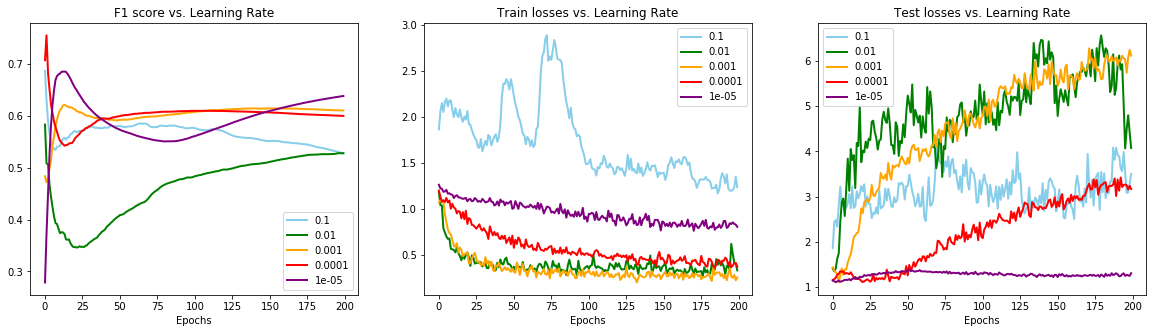

In [8]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch, "Learning Rate")

In [9]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python file
import pickle
with open('resultsAttentionLearningRate_ANM.pickle', 'wb') as f:
    pickle.dump( rSnpRnaA_tst_nXNS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rSnpRnaB_tst_nXNS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( attention_matrixA, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( attention_matrixB, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( tst_prediction, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    


Data saved into pickle.
